# Analytical simulation of three terminal heterojunction bipolar transistor solar cells

## Libraries that are needed 
* Matplotlib is the library we use for our plots. It has several "backends".They are called with the % prefix. Examples of "backends" are "inline" (that does not allow to modify the figures) and "notebook" that allows to interact with the figures. By default we will use "notebook" back end
* numpy is the library that contains numerical functions
* sympy is the library that allows symbolic calculations
* pandas is the library that allows importing data from Excel files
* mathplotlib.pyplot actually calls the library that allows plotting functions

In [199]:
%matplotlib notebook
import numpy as np
import sympy as sp
from sympy import *
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

## Absorption coefficients
In the same subdirectory than this program we create Excel files containg the absorption coeficient of the materials we want to use. As an example, we will use GaAs for both the base, emitter and collector. The following lines assign the absorption coefficient to each region. For the momemnt, the available data files are:
* GaAs_Abs.xls for pure GaAs
* Al0315GaAs_Abs.xlsx for pure Al$_{0.315}$Ga$_{0.685}$As
* Al0590GaAs_Abs.xlsx for pure Al$_{0.59}$Ga$_{0.41}$As
* Silicon_Abs.xlxs for pure silicon
* CH3NH3PbI3_perovskite.xlsx for CH3NH3PbI3 perovskite

In [123]:
emitter_abs = pd.read_excel (r'GaAs_Abs.xlsx', sheet_name='absorption')
base_abs= pd.read_excel (r'GaAs_Abs.xlsx', sheet_name='absorption')
collector_abs=pd.read_excel (r'GaAs_Abs.xlsx', sheet_name='absorption')

As an example, we read next the absorption coefficients that will be asigned to the emitter

In [124]:
print(emitter_abs['Alfa (cm-1)'])

0         0.000
1        11.918
2        16.519
3        23.779
4        36.239
5        55.210
6        85.720
7       133.110
8       206.680
9       327.060
10      507.750
11      936.000
12     1481.000
13     2343.000
14     3706.900
15     5866.000
16     7975.000
17     7996.000
18     8820.000
19     9364.000
20     9754.000
21    10358.000
22    10585.000
23    11239.000
24    11934.000
25    12196.000
26    12704.000
27    13235.000
28    13786.000
29    14360.000
30    14676.000
31    14998.000
32    14998.000
Name: Alfa (cm-1), dtype: float64


We create next interpolating functions for the absorption coefficients for the materials in each of the regions. These functions are aE, aB and aC

In [125]:
x=np.array([emitter_abs['Energy (eV)']])[0]
y=np.array([emitter_abs['Alfa (cm-1)']])[0]
aE=interp1d(x,y)
x=np.array([base_abs['Energy (eV)']])[0]
y=np.array([base_abs['Alfa (cm-1)']])[0]
aB=interp1d(x,y)
x=np.array([collector_abs['Energy (eV)']])[0]
y=np.array([collector_abs['Alfa (cm-1)']])[0]
aC=interp1d(x,y)

Hence, for example, aE(1.55) will give us the interpolated absorption coefficient of the emitter material for 1.55 eV:

In [126]:
aE(1.55)

array(13133.97867692)

In [127]:
print(aE(1.55))
print(aB(1.56))
print(aC(1.57))

13133.978676920393
13627.396267637694
14143.339038601605


## Notation
Fig. 1 describes the notation we will use to locate some critical points within the structure of a three-terminal heterojuncion bipolar transistor solar cell (3T-HBTSC). The calculations are done for a pnp transitor; however since we work in terms of "minority carriers" the results are valid also for a npn transitor by just reversing the sign of the currents obtained by using this model.

<img src="3T_structure.png" width="900">
<p style="text-align: center;">Fig. 1</p>

Notice the solar cell is illuminated from the emitter region. The structure chosen for the illustration corresponds to a pnp structure. Be careful in distinguishing between "physical thickness" and "x coordinates" as described next 

* The origin 0, is located at the interface between the emitter and the base
* $W_E$ is the thickness of the emitter. The x-coordinate of the emitter surface is $-W_E$.
* $x_{pE}$ is the thickness of the space charge region at the emitter side of the emitter-base junction. The x-coordinate of the edge of the space-charge region at the emitter side of the emitter-base junction is $-x_{pE}$.
* $x_{nE}$ is the thickness of the space charge region at the base side of the emitter-base junction. The x-coordinate of the edge of the space-charge region at the base side of the emitter-base junction is $x_{nE}$.
* $W_B$ is the thickness of the base. The x-coordinate of the interface between the base and the collector is $W_B$.
* $x_{nC}$ is the x-coordinate of the edge of the space charge region beetween the base and the colector at the base side. $W_B-x_{nC}$ is, then, the physical width of the space charge region between the base and the collector at the base side.
* $x_{pC}$ is the x-coordinate of the edge of the space charge region beetween the base and the colector at the collector side. $x_{pC}- W_B$ would be, then, the physical width of the space charge region between the base and the collector at the base side.
* $W_{C}$ is the x-coordinate of the collector surface.  $W_{C}- W_B$ would be, then, the physical thickness of the collector.

## Variables for symbolic calculations
The equations needed for the simulation are derived using Python power for symbolic calculations through the library "sympy". This requires the definition of the variables that are going to be "symbolic" and the functions we are going to use. Hence:
* alf is the absorption coefficient for a given wavelength. Is used for the symbolic calculation of the quantum efficiency (QE) of the emitter, base and collector.
* alfaE is the absorption coefficient of the emitter. Is needed tor the symbolic calculation of the quantum efficiency of the base and collector in order to calculate how much light has been absorbed in the emitter before reaching the base and the collector.
* alfaB is...need for calculating QE collector
* WB is ..need for calculating QE collector
* WE is the total thickness of the emitter (including the part of the space charge region that falls in the emitter side). It is needed for the symbolic calculation of the quantum efficiency of the base and the collector in order to know how much light has been absorbed in the emitter before reahicg the base and the collector.
* xnE is the thickness of the space charge region at the emitter-base junction at the base side. It is needed for the symbolic calculation of the quantum efficiency of the base
* x is the coordinate x
* D is the minority carrier diffusion constant in the region of interest (emitter, base or collector, depending on the case)
* t is the minority carrier lifetime in the region of interest
* W  is a variable aiming to introduce the thickness of the region of interest
* ni is the intrinsic concentration of the material in the region of interest
* N is the doping concentration in the region of interest
* k is the Boltzman constant
* T is the absolute temperature
* e is the electron charge (in absolute value)
* V is the voltage applied between the emitter and the base or between th colector and the base, depending on the region being solved
* S is the surface recombination of the region of interest. It is only of interest for the emitter and the collector because the base has no surfaces because it is sandwitched in-between two pn-junctions)
* y0 is the value our function "y" takes at one of the boundaries, the one at the "left"
* yW is that value our function "y" takes at one of the boundaries, the one at the "right"
* xE is a dum variable we needed to solve symbolically the acuations related to the quantum efficiency
* WL is the coordinate x defining the left side of the base region (** might be redundant with xne **)
* WR is the coordinate x defining the right side of the base region
* yWL is the value of the function "y" at WL
* yWR is the value of the function "y" at WR
* V2 is the value of the voltage at the base-collector junction

In [128]:
y = symbols('y',cls=Function)
x,D,t,W,ni,N,k, T, e, V, S, y0, yW, xE, WL, WR, yWL, yWR, V2,alf,c, alfaE,alfaB, WE,WB, xnE= symbols('x D t W ni N k T e V S y0 yW xE WL WR yWL yWR V2 alf c alfaE alfaB WE WB xnE')

## Dictionaries
Dictionaries (a concept of the Python language) will be used to intruduce the value of parameters such as thickness, dopings, minority carriers values related to the emitter, base and collector. The same name than the one used for the symbolic variables have been used when considered convinent in order to simplify later the asignation of numerical values to the functions obtained by means of symbolic calculations. Hence,
* dictE is the dictionary that icollects the value of the parameters related to the emitter
    * D is the minority carrier difussion constant ($cm^2s^{-1}$)
    * S is the surface recombination at the emitter ($cm s^{-1}$)
    * t is the minority carrier lifetime (s)
    * ni is the intrinsic concentration of the semiconductor the emitter is made off ($cm^{-3}$)
    * N is the doping of the emitter (all impurities are assumed to be ionized) ($cm^{-3}$)
    * W is the physcial thickness of the emitter, ($W_E$ ($cm^{-3}$) (**ojo porque es negativo en el diccionario, mejor definirlo como la coordenada. hay que pasar todas las coordenadas
    * xE is the physical thickness of the space charge region at the emitter side, ($x_{pE}$ ($cm^{-3}$)
    * alf is the absorption coefficient of the emitter (cm$^{-1}$)
* dictB is the dictionary that includes parameters related to the base
    * D is the minority carrier difussion constant ($cm^2s^{-1}$)
    * t is the minority carrier lifetime (s)
    * ni is the intrinsic concentration of the semiconductor the base is made off ($cm^{-3}$)
    * N is the doping of the base (all impurities are assumed to be ionized) ($cm^{-3}$)
    * WL is the coordinate of the space charge region in the base at the left side ($W_L=x_{nE}$)
    * WR is the coordinate of the space charge region in the base at the right side ($W_R=x_{nC}$)
    * W is the x-coordinate of the extreme of the base ($W_B$). Due to choice of the zero in the x axis, it is also the thickness of the base. (cm)
    * alf is the absorption coefficient of the emitter (cm$^{-1}$)
* dictC is the dictionary that includes the parameters related to the collector
    * D is the minority carrier difussion constant ($cm^2s^{-1}$)
    * S is the surface recombination at the emitter ($cm s^{-1}$)
    * t is the minority carrier lifetime (s)
    * ni is the intrinsic concentration of the semiconductor the emitter is made off ($cm^{-3}$)
    * N is the doping of the emitter (all impurities are assumed to be ionized) ($cm^{-3}$)
    * W is the x-coordinate of the extreme of the collector $W_C$ not the thickness of the collector!
    * xE is the x- coordinate of the edge of the space charge region at the edge of the collector ($cm$) 
    * alf is the absorption coefficient of the emitter (cm$^{-1}$)

* dictCTE is the dictionary that contains physical constants and othe variables that do not depend on the region being considered
    * k is the Boltzman constant ($JK^{-1}$)
    * T is the temperature of operation ($K$)
    * e is the electron charge in absolute value ($C$)
* AE is the area of the emitter-base junction (cm$2$)
* AC is the area of the colector-base junction (cm$2$) (Note: The model developed here is unidimensional. If the areas AE and AC are not equal it means our device is, at least, bidemensional. This has to be kept in mind when fitting experimental reults) 

In [129]:
AE=1
AC=1
dictE={D:25,S:1000,t:10**(-9),ni:10**10,N:2*10**18,W:-10**-4,xE:0,alf:10**3}
dictB={D:25,t:10**(-9),ni:10**10,N:2*10**18,WL:0,WR:100*10**-4,W:100*10**-4, alf:10**4}
dictC={D:25,S:1000,t:10**(-9),ni:10**10,N:2*10**18,W:110*10**-4,xE:100*10**-4,alf:10**4}
dictCTE={k:1.38*10**-23,T:300,e:1.6012*10**-19}

For convenience, to reduce the number of arguments passed later to the functions, we merge the physical constants dictionary with the emitter, base and collector dictionaries.

In [130]:
dictE={**dictE,**dictCTE}
dictB={**dictB,**dictCTE}
dictC={**dictC,**dictCTE}
print(dictE,dictB,dictC);

{D: 25, S: 1000, t: 1e-09, ni: 10000000000, N: 2000000000000000000, W: -0.0001, xE: 0, alf: 1000, k: 1.3799999999999998e-23, T: 300, e: 1.6011999999999998e-19} {D: 25, t: 1e-09, ni: 10000000000, N: 2000000000000000000, WL: 0, WR: 0.01, W: 0.01, alf: 10000, k: 1.3799999999999998e-23, T: 300, e: 1.6011999999999998e-19} {D: 25, S: 1000, t: 1e-09, ni: 10000000000, N: 2000000000000000000, W: 0.011000000000000001, xE: 0.01, alf: 10000, k: 1.3799999999999998e-23, T: 300, e: 1.6011999999999998e-19}


## Calculation of the emitter minority carrier profile in dark

We solve in this section symbolically the continuity equation for minority carriers in dark conditions in the emmitter under the hypothese of low injection

$$ D \frac {dy}{dx}-\frac{y}{\tau}=0$$
$$ \frac{dy}{dx}(-W_E)=y_W $$
$$ y(-x_{pE})=y_0 $$

where

* $y \equiv \Delta m$ is the excess of minority carriers concentration
* $D$ is the minority carriers diffusion constant
* $\tau$ is the minority carriers lifetime

The boundary conditions are written in this way for convenience when using the python library "sympy" since this library does not allow us to write the boundary conditions in a direct way. For example, we cannot directly write (or we don't know how to do it):

$$ D \frac{dy}{dx}(-W_E)=S y(W_E) $$

where $S$ is the surface recombination, nor

$$ y(-x_{pE})=\frac{n_i^2}{N_E} \left( \exp \frac{eV}{kT} -1 \right)$$

where $N_i^2 is the intrinsic carrier concentracion at the emitter.  Instead, in the way we are forzed to express the boundary conditions, we would have then that:

$$ y_W=\frac{y(-W_E)}{S} $$
$$ y(-x_{pE})=\frac{n_i^2}{N_E} \left( \exp \frac{eV}{kT} -1 \right) $$



We formulate next, then, symbolically the continuity ecuation and its boundary conditions. Temporarelly, in this section, W is the position of the extreme of the emitter. It will have a negative value because we have taken the origin x=0 at the interface between emitter and base. Similarly xE is the position of the extreme of the space charge region between emitter and base at the side of the emitter. It will have to take negative values. y0 is the value of the function y at xE and yW is the value of the derivative of y at W. As explained above, this conditions are formulated in this way in order to later being able of introducing surface recombination as boundary consition since sympy does not allow us to do it here in a straight forward way.

In [131]:
diffeqJE=Eq(D*y(x).diff(x,x)-y(x)/t,0)
solJE=dsolve(diffeqJE,y(x),ics={y(x).diff(x).subs(x,W):yW,y(xE):y0})
solJE

Eq(y(x), (-D*t*yW*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + y0*exp(W*sqrt(1/(D*t))))*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (y0*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + yW*exp(W*sqrt(1/(D*t))))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

We substitute the value of the boundary condition y0

In [132]:
solJE=solJE.subs(y0,ni**2/N*(exp(e*V/k/T)-1))
solJE

Eq(y(x), (-D*t*yW*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (yW*exp(W*sqrt(1/(D*t))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

We find the value of the boundary condition yW that satisfies:
$$ D\frac{\Delta m}{\Delta x}(W)=S \Delta m (W)$$
where S is the surface recombination at the emitter and D the minority carrier diffussion constant

In [133]:
susJE=solve(solJE.rhs.subs(x,W)-D/S*yW,0,yW)
susJE

[{yW: 2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t)))))}]

Once we have calculated yW, we inserte it back into "sol" 

In [134]:
solJE=solJE.subs(yW,susJE[0].get(yW))
solJE

Eq(y(x), (-2*D*S*ni**2*t*1/(D*t)*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

We now calculate the derivate of y, that we will need later to calculate the current density:
$$dy \equiv \frac{d \Delta m}{d x}$$

In [135]:
dyJE=solJE.rhs.diff(x)
dyJE

-sqrt(1/(D*t))*(-2*D*S*ni**2*t*1/(D*t)*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))

We define the function jeE that, as a function of the voltage V of the emitter-base junction and the dictionary containing the parameters of the emitter, allow us to calculate the minotity carrier current density at the emitter evaluated at the emitter-base junction.

In [136]:
def jeE(v,dic):
    dict={**dic, V:v,x:dic.get(xE)}
    resul=dyJE.evalf(subs=dict)*dic.get(D)*dict.get(e)*AE
    return resul

We run a test on the value of current density for a voltage v=0.4 V. Result is in Acm$^{-2}$

In [137]:
jeE(0.4,dictE)

3.73666107156955e-6

## Calculation of the base minority carrier profile in dark

We solve the continuity equation for minority carriers in the base. yWL is the boundary condition we set for the function y at x=WL and yWR is the value of the boundary condition for the function y we set at x=WR

$$ D \frac {dy}{dx}-\frac{y}{\tau}=0$$
$$ y(WL)=yWL $$
$$ y(WR)=yWR $$

where:
* $y$ is the minority carrier concentration at the base
* $D$ is the minority carrier diffusion constant at the base
* $\tau$ is the minority carrier lifetime at the base
* $WL \equiv x_{nE}$
* $WR \equiv x_{nC}$
* $yWL \equiv \frac{n_i^2}{N_E} \left( \exp \frac{eV}{kT} -1 \right)$
* $yWR \equiv \frac{n_i^2}{N_E} \left( \exp \frac{eV2}{kT} -1 \right)$




In [138]:
diffeqJB=Eq(D*y(x).diff(x,x)-y(x)/t,0)
solJB=dsolve(diffeqJB,y(x),ics={y(WL):yWL,y(WR):yWR})
solJB

Eq(y(x), (yWL*exp(WL*sqrt(1/(D*t))) - yWR*exp(WR*sqrt(1/(D*t))))*exp(x*sqrt(1/(D*t)))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t)))) + (-yWL*exp(WR*sqrt(1/(D*t))) + yWR*exp(WL*sqrt(1/(D*t))))*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(WL + WR))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t)))))

We substitute now the value of the boundary conditions. We recall V is the voltage of the base-emitter junction and V2 is the voltage of the base-colector junction

In [139]:
solJB=solJB.subs({yWL:ni**2/N*(exp(e*V/k/T)-1),yWR:ni**2/N*(exp(e*V2/k/T)-1)})
solJB

Eq(y(x), (ni**2*(exp(V*e/(T*k)) - 1)*exp(WL*sqrt(1/(D*t)))/N - ni**2*(exp(V2*e/(T*k)) - 1)*exp(WR*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t)))) + (-ni**2*(exp(V*e/(T*k)) - 1)*exp(WR*sqrt(1/(D*t)))/N + ni**2*(exp(V2*e/(T*k)) - 1)*exp(WL*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(WL + WR))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t)))))

We calculate the derivative of the minority carrier profile at the base, dyB

In [140]:
dyJB=solJB.rhs.diff(x)
dyJB

sqrt(1/(D*t))*(ni**2*(exp(V*e/(T*k)) - 1)*exp(WL*sqrt(1/(D*t)))/N - ni**2*(exp(V2*e/(T*k)) - 1)*exp(WR*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t)))) - sqrt(1/(D*t))*(-ni**2*(exp(V*e/(T*k)) - 1)*exp(WR*sqrt(1/(D*t)))/N + ni**2*(exp(V2*e/(T*k)) - 1)*exp(WL*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(WL + WR))/(exp(2*WL*sqrt(1/(D*t))) - exp(2*WR*sqrt(1/(D*t))))

We define now the functions that allow us to calculate the minority carrier current crossing the emitter-base junction, jeB, and the minority carrier current density crossing the base-collector junction due to minority carriers in the base, jcB

In [141]:
def jeB(v,v2,dic):
    dict={**dic, V:v,V2:v2, x:dic.get(WL)}
    resul=-dyJB.evalf(subs=dict)*dict.get(D)*dict.get(e)*AE
    return resul

In [142]:
def jcB(v,v2,dic):
    dict={**dic, V:v,V2:v2, x:dic.get(WR)}
    resul=-dyJB.evalf(subs=dict)*dict.get(D)*dict.get(e)*AC
    return resul

We next test the functions jeB and jcB. Results are in Acm$^{-2}$. Notice that when the base is very long, jcB is negative but when the base is short, due to the transistor effect, jcB is positive

In [143]:
jeB(0.4,.2,dictB)

6.62448203505071e-6

In [144]:
jcB(0.4,0.2,dictB)

-2.89453571455237e-9

## Calculation of the collector minority carrier profile in dark
We do not need to carry out the calculations since the differential equation ruling the minority carriers in the collector is the same one than in the emitter with the appriate change of parameters. Therefore, we can use the solution we obtained from the emitter and define the function jeC accordingly to calculate the current density due to the minority carriers excess in the collector. ** hemos substraido la coordenada WR de la base de la condicion de contorno. no se pasa como argumento para que no parezca que depende de esa variable.pasarla como variable?

In [145]:
diffeqJC=Eq(D*y(x).diff(x,x)-y(x)/t,0)
solJC=dsolve(diffeqJC,y(x),ics={y(x).diff(x).subs(x,W):yW,y(xE):y0})
solJC

Eq(y(x), (-D*t*yW*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + y0*exp(W*sqrt(1/(D*t))))*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (y0*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + yW*exp(W*sqrt(1/(D*t))))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

In [146]:
solJC=solJC.subs(y0,ni**2/N*(exp(e*V/k/T)-1))
solJC

Eq(y(x), (-D*t*yW*sqrt(1/(D*t))*exp(xE*sqrt(1/(D*t))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (yW*exp(W*sqrt(1/(D*t))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

In [147]:
susJC=solve(solJC.rhs.subs(x,W)-D/S*yW,0,yW)
susJC

[{yW: 2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t)))))}]

In [148]:
solJC=solJC.subs(yW,susJC[0].get(yW))
solJC

Eq(y(x), (-2*D*S*ni**2*t*1/(D*t)*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

In [149]:
dyJC=solJC.rhs.diff(x)
dyJC

-sqrt(1/(D*t))*(-2*D*S*ni**2*t*1/(D*t)*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))/N)*exp(-x*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t)))) + (2*S*ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(W*sqrt(1/(D*t)))*exp(sqrt(1/(D*t))*(W + xE))/(N*(D*sqrt(1/(D*t))*exp(2*W*sqrt(1/(D*t))) + D*sqrt(1/(D*t))*exp(2*xE*sqrt(1/(D*t))) - S*exp(2*W*sqrt(1/(D*t))) + S*exp(2*xE*sqrt(1/(D*t))))) + ni**2*sqrt(1/(D*t))*(exp(V*e/(T*k)) - 1)*exp(xE*sqrt(1/(D*t)))/N)*exp(x*sqrt(1/(D*t)))/(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))

In [150]:
def jcC(v,dic):
    dict={**dic, V:v,x:dic.get(xE)}
    resul=dyJC.evalf(subs=dict)*dict.get(D)*dict.get(e)*AC
    return resul
    #return dict

In [151]:
#def jcC(v,dic):
 #   dict={**dic, V:v,x:-dic.get(xE)+dictB.get(WR)}
  #  resul=dyJE.evalf(subs=dict)*dict.get(D)*dict.get(e)*AC
    # return resul
   # return dict

We test next the function for a forward voltage applied at the collector-base junction of 0.4 V. Results are in Acm$^{-2}$

In [152]:
jcC(0.4,dictC)

-6.62443895908027e-6

## Calculating and ploting the dark current-voltage  characteristics


<img src="3T_currents_dark.png" width="900">
<p style="text-align: center;">Fig. 2</p>

Fig.2 illustrates the sign criteria that will be followed in the following examples in order to calculate the emitter, base and collector currents. Hence, for example, the emitter current, $I_E$ will be considered "positive" if it "enters" the emitter and the collector current $I_C$ will be considered positive if it exits the collector. Notice that if the transitor would be npn the actual sense of the current would reverse its sign from the one obtained here.

Hence, the following is an example of collector current-voltage characteristic for a constant emitter-base voltage VEB=0.4 V. Vi is the initial voltage, VF is the final voltage and Vstep is the voltage step for the plot. Users can hopefully easily edit the next code for adapting the plot to their needs

In [203]:
VEB=0.4
Vi=0.
Vf=1.
Vstep=0.01
# Data for plotting
elist = np.arange(Vi, Vf, Vstep)
curve=[]

for i in elist:
    curve.append([jcC(i,dictC),jcB(VEB,i,dictB),jcC(i,dictC)+jcB(VEB,i,dictB)])

<IPython.core.display.Javascript object>


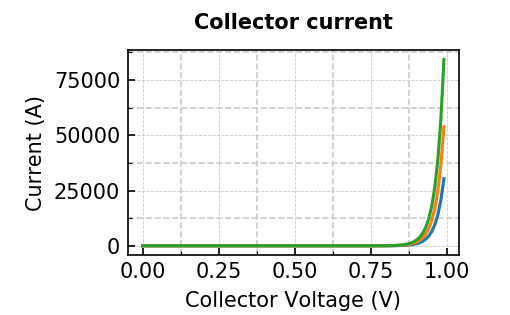

In [254]:
fig_width = 3.4
golden = 1.618
fig = plt.figure(figsize=(fig_width, fig_width/golden), dpi=150)
ax = fig.add_axes([0.25, 0.19, 0.65, 0.65])
ax.plot(elist, curve)

ax.set_ylabel('Current (A)', size=10)
ax.set_xlabel('Collector Voltage (V)', size=10)
ax.set_title('Collector current', size=10, weight='bold', pad=10)
ax.grid(which='both', c='0.8', ls='--')
ax.grid(which='major', lw=1.2)
ax.grid(which='major', lw=0.4)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction="in")

fig.savefig("test.png", dpi=300)
plt.show()

## Emitter current-voltage characteristics
Similarly, the following is an example of code that alloes plotting the emitter current-voltage characteristics for a given constant base-collector voltage VBC=0.4 V

<IPython.core.display.Javascript object>


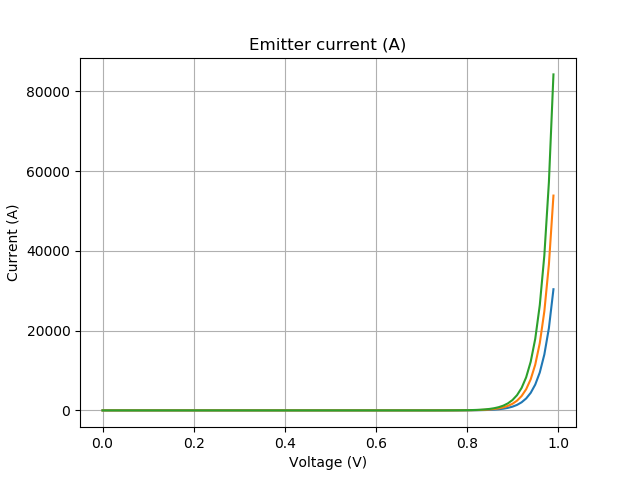

In [211]:
VBC=0.4
Vi=0.
Vf=1.
Vstep=0.01
# Data for plotting
elist = np.arange(Vi, Vf, Vstep)
curve=[]

for i in elist:
    curve.append([jeE(i,dictE),jeB(i,VBC,dictB),jeE(i,dictE)+jeB(i,VBC,dictB)])

fig, ax = plt.subplots()
ax.plot(elist, curve)

ax.set(xlabel='Voltage (V)', ylabel='Current (A)',
       title='Emitter current (A)')
ax.grid()

fig.savefig("test.png")
plt.show()

## Base current-voltage characteristics
The following is an example to calculate the base current as a function of VBE $I_B$ when the  the collector-base juntion is biased with VBC=0.4 V

<IPython.core.display.Javascript object>


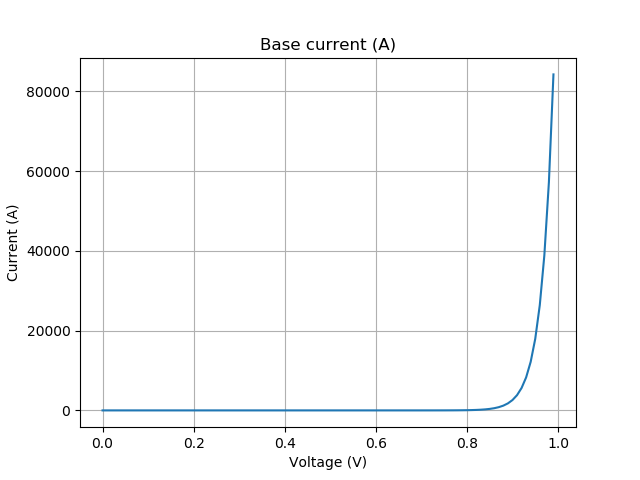

In [155]:
VBC=0.4
Vi=0.
Vf=1.
Vstep=0.01
# Data for plotting
elist = np.arange(Vi, Vf, Vstep)
curve=[]

for i in elist:
    curve.append([-jcB(i,VBC,dictB)-jcC(VBC,dictC)+jeB(i,VBC,dictB)+jeE(i,dictE)])

fig, ax = plt.subplots()
ax.plot(elist, curve)

ax.set(xlabel='Voltage (V)', ylabel='Current (A)',
       title='Base current (A)')
ax.grid()

fig.savefig("test.png")
plt.show()

## Emitter contribution to the emitter quantum efficiency 

For calculating the contribution of the emitter to the quantum efficiency of the total emitter photocurrent, we need to solve the following differential Eq:

$$ D \frac {dy}{dx}-\frac{y}{\tau}=-\alpha \exp \left( -\alpha (x-W)) \right)$$
$$ \frac{dy}{dx}(-W_E)=y_W $$
$$ y(-x_{pE})=y_0 $$

where, as usual

* $y \equiv \Delta m$ is the excess of minority carrier concentration
* $D$ is the minority carrier diffusion constant
* $\tau$ is the minority carrier lifetime
* $\alpha$ is the light absorption coeffient of the emitter for the wavelength of interest
* $W$ is the position in the x-coordinate of the front surface of the emitter

This differential equation models the ambipolar drift-diffusion  equation in low injection for the p emitter region of the cell assuming one photon per cm-3, sec of a given wavelength incides on the solar cell from the emitter side. 

Due to limitations in Python symbolic calculations routines, we are forced to write:

$$ \exp \left( -\alpha (x-W) \right) = c \exp \left( -\alpha x \right) $$

where

$$c = \exp \left( \alpha W \right) $$

Also, for the quantum efficiency, we have

$$ y_0=0$$
$$ y_W=S y(-W_E)$$

but, we prefer to do these substitutions later since, as it occurred when solving for dark conditions, we found some problems if we substitute now. Hence:


In [156]:
diffeqQE=Eq(D*y(x).diff(x,x)-y(x)/t,-alf*c*exp(-alf*x))
solQE=dsolve(diffeqQE,y(x),ics={y(x).diff(x).subs(x,W):yW,y(xE):y0})
solQE

Eq(y(x), -alf*c*t*exp(-alf*x)/(D*alf**2*t - 1) + (sqrt(1/(D*t))*(D*alf**2*t*y0*exp(xE*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(xE*sqrt(1/(D*t))) - y0*exp(xE*(alf + sqrt(1/(D*t)))))*exp(W*alf) - (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*c*t*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(alf*xE))*exp(-alf*(W + xE))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))) + (sqrt(1/(D*t))*(D*alf**2*t*y0*exp(xE*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(xE*sqrt(1/(D*t))) - y0*exp(xE*(alf + sqrt(1/(D*t)))))*exp(W*(alf + 2*sqrt(1/(D*t)))) + (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*c*t*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(xE*(alf + 2*sqrt(1/(D*t)))))*exp(-alf*(W + xE))*exp(-x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

Now we proceed with the "easy" substitutions, the ones for "c" and y0

In [157]:
solQE=solQE.subs(y0,0)
solQE=solQE.subs(c, exp(alf*W))
solQE

Eq(y(x), -alf*t*exp(W*alf)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*sqrt(1/(D*t))*exp(2*W*alf)*exp(xE*sqrt(1/(D*t))) - (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*t*exp(W*alf)*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(alf*xE))*exp(-alf*(W + xE))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))) + (alf*t*sqrt(1/(D*t))*exp(W*alf)*exp(W*(alf + 2*sqrt(1/(D*t))))*exp(xE*sqrt(1/(D*t))) + (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*t*exp(W*alf)*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(xE*(alf + 2*sqrt(1/(D*t)))))*exp(-alf*(W + xE))*exp(-x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

And now we substitute for yW, which will require some symbolic calculations ** hay que poner 0 o -xpe?

In [158]:
susQE=solve(solQE.rhs.subs(x,W)-D/S*yW,0,yW)
susQE

[{yW: S*alf*t*(S*t*sqrt(1/(D*t))*(-D*alf**2*t*exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) + D*alf**2*t*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t))) + exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) - exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) + (D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE))*(D*alf*t*sqrt(1/(D*t))*(-exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) + exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) - (exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE) + 2*exp(3*W*alf + 2*W*sqrt(1/(D*t)) + alf*xE + 3*xE*sqrt(1/(D*t))) + 2*exp(3*W*alf + 4*W*sqrt(1/(D*t)) + alf*xE + xE*sqrt(1/(D*t))))*exp(-2*alf*(W + xE))/(D*(S*t*sqrt(1/(D*t))*(D*alf**2*t*exp(xE*(alf + 4*sqrt(1/(D*t)))) + D*alf**2*t*exp(2*W*sqrt(1/(D*t)) + xE*(alf + 2*sqrt(1/(D*t)))) - D*alf**2*t*exp(4*W*sqrt(1/(D*t)) + alf*xE) - D*alf**2*t*exp(2*W*sqrt(1/(D*t)) + alf*xE

In [159]:
solQE=solQE.subs(yW,susQE[0].get(yW))
solQE=solQE.subs(c, exp(alf*W))
solQE;

We calculate next the derivative of "y" that we will need for calculating the photocurrent induced by photon absorption in the emitter.   **arriba no hace falta sustituir ya c

In [160]:
dyQE=solQE.rhs.diff(x)
dyQE

alf**2*t*exp(W*alf)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*sqrt(1/(D*t))*exp(2*W*alf)*exp(xE*sqrt(1/(D*t))) - (-S*alf**3*t**2*(S*t*sqrt(1/(D*t))*(-D*alf**2*t*exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) + D*alf**2*t*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t))) + exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) - exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) + (D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE))*(D*alf*t*sqrt(1/(D*t))*(-exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*alf*xE) + exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) - (exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*alf*xE) + 2*exp(3*W*alf + 2*W*sqrt(1/(D*t)) + alf*xE + 3*xE*sqrt(1/(D*t))) + 2*exp(3*W*alf + 4*W*sqrt(1/(D*t)) + alf*xE + xE*sqrt(1/(D*t))))*exp(W*(alf + sqrt(1/(D*t))))*exp(-2*alf*(W + xE))/(S*t*sqrt(1/(D*t))*(D*alf**2*t*exp(xE*(alf + 4*sqrt(1/(D*t)))) + D*alf**2*t*exp

The quantum efficiency is the phocurrent per unit of charge, calculated at $-x_{pE}$;

$$QEe= \frac {D \frac {dy}{dx}}  { 1 cm^{-2} s^{-1}}(-x_{pE})$$

calculated with minority carrier parameters corresponding to the emitter. In Python language:

In [161]:
#version independent of the photon energy
#def QEe(dic):
 #   dict={**dic, x:dic.get(xE)}
  #  resul=dy.evalf(subs=dict)*dic.get(D)
   # return resul

In [162]:
def QEe(energy,dic):
    dict={**dic, x:dic.get(xE), alf:float(aE(energy))}
    resul=dyQE.evalf(subs=dict)*dic.get(D)
    return resul

In [163]:
QEe(1.6, dictE)

-0.671009187584564

## Base contribution to the emitter quantum efficiency 

For calculating the contribution of the base to the quantum efficiency of the total emitter photocurrent as well as to the total collector photocurrent, we also need to solve the following differential Eq:

$$ D \frac {dy}{dx}-\frac{y}{\tau}=-\alpha \exp \left( -\alpha_E W_E \right) \exp \left( -\alpha x \right)$$
$$ y(x_{nC})=y_W $$
$$ y(x_{nE})=y_0 $$

where, as usual

* $y \equiv \Delta m$ is the excess of minority carrier concentration
* $D$ is the minority carrier diffusion constant
* $\tau$ is the minority carrier lifetime
* $\alpha$ is the light absorption coeffient of the base for the wavelength of interest
* $W_E$ is the thickness of the emitter
* $\alpha_E$ is the absorption coefficient of the emitter for the wavelength of interest
* $x_{nE}$ is the position in the x coordinate of the edge of the space charge region of the base-emitter junction at the base side
* $x_{nC}$ is the position in the x coordinate of the edge of the space charge region of the base-collector  junction at the base side

Notice this differential Eq. is written in this way because the origin of the base is at $x=0$.

Due to limitations in Python symbolic calculations routines, we are forced to write:

$$  \exp \left( -\alpha_E W_E \right) \exp \left( -\alpha x \right) = c \exp \left( -\alpha x \right) $$

where

$$c = \exp \left(-\alpha_E W_E \right) $$

Also, for the quantum efficiency, for the base, because it is bounded by two pn junctions that for the calculation have to be assumed biased at zero volts, we have

$$ y_0=0$$
$$ y_W=0$$

In this case, we could easily write in Python this boundary conditions, but we prefer to keep the structure of the previous sections and make the substitutions later since, in this way, it is easier to correct for errors. 

Hence:

 


In [164]:
diffeqQB=Eq(D*y(x).diff(x,x)-y(x)/t,-alf*c*exp(-alf*x))
solQB=dsolve(diffeqQB,y(x),ics={y(WL):yWL,y(WR):yWR})
solQB

Eq(y(x), -alf*c*t*exp(-alf*x)/(D*alf**2*t - 1) + (-(D*alf**2*t*yWL*exp(WL*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(WL*sqrt(1/(D*t))) - yWL*exp(WL*(alf + sqrt(1/(D*t)))))*exp(WR*alf) + (D*alf**2*t*yWR*exp(WR*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(WR*sqrt(1/(D*t))) - yWR*exp(WR*(alf + sqrt(1/(D*t)))))*exp(WL*alf))*exp(-alf*(WL + WR))*exp(x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t))))) + ((D*alf**2*t*yWL*exp(WL*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(WL*sqrt(1/(D*t))) - yWL*exp(WL*(alf + sqrt(1/(D*t)))))*exp(WR*(alf + 2*sqrt(1/(D*t)))) - (D*alf**2*t*yWR*exp(WR*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(WR*sqrt(1/(D*t))) - yWR*exp(WR*(alf + sqrt(1/(D*t)))))*exp(WL*(alf + 2*sqrt(1/(D*t)))))*exp(-alf*(WL + WR))*exp(-x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t))))))

In [165]:
solQB=solQB.subs({yWL:0,yWR:0})
solQB=solQB.subs(c, exp(-alfaE*WE))
solQB

Eq(y(x), -alf*t*exp(-WE*alfaE)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*exp(-WE*alfaE)*exp(WL*alf)*exp(WR*sqrt(1/(D*t))) - alf*t*exp(-WE*alfaE)*exp(WL*sqrt(1/(D*t)))*exp(WR*alf))*exp(-alf*(WL + WR))*exp(x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t))))) + (alf*t*exp(-WE*alfaE)*exp(WL*sqrt(1/(D*t)))*exp(WR*(alf + 2*sqrt(1/(D*t)))) - alf*t*exp(-WE*alfaE)*exp(WL*(alf + 2*sqrt(1/(D*t))))*exp(WR*sqrt(1/(D*t))))*exp(-alf*(WL + WR))*exp(-x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t))))))

We now calculate the derivative of the minority carrier concentration

In [166]:
dyQB=solQB.rhs.diff(x)
dyQB

alf**2*t*exp(-WE*alfaE)*exp(-alf*x)/(D*alf**2*t - 1) + sqrt(1/(D*t))*(alf*t*exp(-WE*alfaE)*exp(WL*alf)*exp(WR*sqrt(1/(D*t))) - alf*t*exp(-WE*alfaE)*exp(WL*sqrt(1/(D*t)))*exp(WR*alf))*exp(-alf*(WL + WR))*exp(x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t))))) - sqrt(1/(D*t))*(alf*t*exp(-WE*alfaE)*exp(WL*sqrt(1/(D*t)))*exp(WR*(alf + 2*sqrt(1/(D*t)))) - alf*t*exp(-WE*alfaE)*exp(WL*(alf + 2*sqrt(1/(D*t))))*exp(WR*sqrt(1/(D*t))))*exp(-alf*(WL + WR))*exp(-x*sqrt(1/(D*t)))/((D*alf**2*t - 1)*(-exp(2*WL*sqrt(1/(D*t))) + exp(2*WR*sqrt(1/(D*t)))))

We calculate next the quantum efficiency of the base at the emitter side. The negative sign of the result verifies that the current flows from right to left, as it should be for the case of a pnp estructure. We prefer to keep the sign because a change in the sign could reveal either an error in the calculations or, perhaps, some impact from the collector is some extreme operation conditions.

In [167]:
#def QEh(dic,dictEMI):
 #   dict={**dic, x:dic.get(WL),WE:-dictEMI.get(W),alf:dic.get(alf),alfaE:dictEMI.get(alf)}
  #  resul=-dyB.evalf(subs=dict)*dict.get(D)
   # return resul

In [168]:
def QEh(energy,dic,dictEMI):
    dict={**dic, x:dic.get(WL),WE:-dictEMI.get(W),alf:float(aB(energy)),alfaE:float(aE(energy))}
    resul=-dyQB.evalf(subs=dict)*dict.get(D)
    return resul

In [169]:
QEh(1.7,dictB,dictE)

-0.156978160440118

We calculate next the quantum efficiency of the base at the collector side. 

In [170]:
#def QCh(dic,dictEMI):
 #   dict={**dic, x:dic.get(WR),WE:-dictEMI.get(W),alf:dic.get(alf),alfaE:dictEMI.get(alf)}
  #  resul=-dyB.evalf(subs=dict)*dict.get(D)
   # return resul

In [171]:
def QCh(energy,dic,dictEMI):
    dict={**dic, x:dic.get(WR),WE:-dictEMI.get(W),alf:float(aB(energy)),alfaE:float(aE(energy))}
    resul=-dyQB.evalf(subs=dict)*dict.get(D)
    return resul

In [172]:
QCh(1.7,dictB,dictE)

7.80751545888580e-29

## QE del colector

For calculating the collector quantum efficiency, we need to solve the following differentail Eq:

$$ D \frac {dy}{dx}-\frac{y}{\tau}=-\alpha \exp \left( -\alpha_E W_E-\alpha_B W_B \right) \exp \left( -\alpha (x-W) \right)$$
$$ y(x_{pC})=y_0 $$
$$ y(W_{C})=y_w $$

where, as usual

* $y \equiv \Delta m$ is the excess of minority carrier concentration
* $D$ is the minority carrier diffusion constant
* $\tau$ is the minority carrier lifetime
* $\alpha$ is the light absorption coeffient of the collector for the wavelength of interest
* $W_E$ is the thickness of the emitter
* $W_B$ is the thickness of the base
* $W$ is the position in the x coordinate of the origin of the collector region ($W_B$)
* $\alpha_E$ is the absorption coefficient of the emitter for the wavelength of interest
* $\alpha_B$ is the absorption coefficient of the base for the wavelength of interes
* $x_{pC}$ is the position in the x coordinate of the edge of the space charge region of the base-collector junction at the collector side
* $W_C$ is the position in the x coordinate of the extreme side of the collector


Due to limitations in Python symbolic calculations routines, we are forced to write:
 
$$  \exp \left( -\alpha_E W_E \right) \exp \left(-\alpha_B W_B \right) \exp \left( -\alpha (x-W_B) \right) = c \exp \left( -\alpha x \right) $$

where

$$c = \exp \left(-\alpha_E W_E \right) \exp \left(-\alpha_B W_B \right) \exp \left( \alpha W \right)  $$

Also, for the quantum efficiency, for the base, because it is bounded by two pn junctions that for the calculation have to be assumed biased at zero volts, we have

$$ y_0=0$$
$$ \frac{dy}{dx}(W_C)=-S y(W_C)$$


Hence: (** W se va a confundir con el espesor del collector

In [173]:
diffeqQC=Eq(D*y(x).diff(x,x)-y(x)/t,-alf*c*exp(-alf*x))
solQC=dsolve(diffeqQC,y(x),ics={y(x).diff(x).subs(x,W):yW,y(xE):y0})
solQC

Eq(y(x), -alf*c*t*exp(-alf*x)/(D*alf**2*t - 1) + (sqrt(1/(D*t))*(D*alf**2*t*y0*exp(xE*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(xE*sqrt(1/(D*t))) - y0*exp(xE*(alf + sqrt(1/(D*t)))))*exp(W*alf) - (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*c*t*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(alf*xE))*exp(-alf*(W + xE))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))) + (sqrt(1/(D*t))*(D*alf**2*t*y0*exp(xE*(alf + sqrt(1/(D*t)))) + alf*c*t*exp(xE*sqrt(1/(D*t))) - y0*exp(xE*(alf + sqrt(1/(D*t)))))*exp(W*(alf + 2*sqrt(1/(D*t)))) + (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*c*t*exp(W*sqrt(1/(D*t))) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(xE*(alf + 2*sqrt(1/(D*t)))))*exp(-alf*(W + xE))*exp(-x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

We make the easy variable substitutions:

In [174]:
solQC=solQC.subs(y0,0)
solQC=solQC.subs(c, exp(-alfaE*WE)*exp(-alfaB*WB)*exp(alf*W))
solQC

Eq(y(x), -alf*t*exp(W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*sqrt(1/(D*t))*exp(2*W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(xE*sqrt(1/(D*t))) - (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*t*exp(W*alf)*exp(W*sqrt(1/(D*t)))*exp(-WB*alfaB)*exp(-WE*alfaE) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(alf*xE))*exp(-alf*(W + xE))*exp(x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))) + (alf*t*sqrt(1/(D*t))*exp(W*alf)*exp(W*(alf + 2*sqrt(1/(D*t))))*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(xE*sqrt(1/(D*t))) + (-D*alf**2*t*yW*exp(W*(alf + sqrt(1/(D*t)))) + alf**2*t*exp(W*alf)*exp(W*sqrt(1/(D*t)))*exp(-WB*alfaB)*exp(-WE*alfaE) + yW*exp(W*(alf + sqrt(1/(D*t)))))*exp(xE*(alf + 2*sqrt(1/(D*t)))))*exp(-alf*(W + xE))*exp(-x*sqrt(1/(D*t)))/(sqrt(1/(D*t))*(D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))))

We substitute now to solve for the boundary condition involving the surface recombination of the collector

In [175]:
susQC=solve(solQC.rhs.subs(x,W)-D/S*yW,0,yW)
susQC

[{yW: S*alf*t*(S*t*sqrt(1/(D*t))*(-D*alf**2*t*exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) + D*alf**2*t*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t))) + exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) - exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) + (D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE))*(D*alf*t*sqrt(1/(D*t))*(-exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE) + exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) - (exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE) + 2*exp(3*W*alf + 2*W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + alf*xE + 3*xE*sqrt(1/(D*t))) + 2*exp(3*W*alf + 4*W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + alf*xE +

In [176]:
solQC=solQC.subs(yW,susQC[0].get(yW))
solQC

Eq(y(x), -alf*t*exp(W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*sqrt(1/(D*t))*exp(2*W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(xE*sqrt(1/(D*t))) - (-S*alf**3*t**2*(S*t*sqrt(1/(D*t))*(-D*alf**2*t*exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) + D*alf**2*t*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t))) + exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) - exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) + (D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE))*(D*alf*t*sqrt(1/(D*t))*(-exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE) + exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) - (exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE

We calculate next the derivative of "y"

In [177]:
dyQC=solQC.rhs.diff(x)
dyQC

alf**2*t*exp(W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(-alf*x)/(D*alf**2*t - 1) + (alf*t*sqrt(1/(D*t))*exp(2*W*alf)*exp(-WB*alfaB)*exp(-WE*alfaE)*exp(xE*sqrt(1/(D*t))) - (-S*alf**3*t**2*(S*t*sqrt(1/(D*t))*(-D*alf**2*t*exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) + D*alf**2*t*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t))) + exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE) - exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) + (D*alf**2*t - 1)*(exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 3*WB*alfaB + 3*WE*alfaE + 2*alf*xE))*(D*alf*t*sqrt(1/(D*t))*(-exp(2*W*alf + 5*W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE) + exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*alf*xE + 4*xE*sqrt(1/(D*t)))) - (exp(2*W*sqrt(1/(D*t))) + exp(2*xE*sqrt(1/(D*t))))**2*exp(2*W*alf + W*sqrt(1/(D*t)) + 2*WB*alfaB + 2*WE*alfaE + 2*al

The quantum efficiency of the collector is the phocurrent per unit of charge, calculated at $x_{pC}$;

$$QEc= \frac {D \frac {dy}{dx}}  { 1 cm^{-2} s^{-1}}(x_{pC})$$

calculated with minority carrier parameters corresponding to the collector. In Python language: 

In [178]:
def QCe(energy,dic,dictE,dictB):
    dict={**dic, x:dic.get(xE), alfaE:float(aE(energy)), alfaB:float(aB(energy)), alf:float(aC(energy)), WE:-dictE.get(W),WB:dictB.get(W)}
    resul=dyQC.evalf(subs=dict)*dic.get(D)
    return resul

In [179]:
QCe(1.5,dictC,dictE,dictB)

1.27622066058217e-43

## Plot of the Collector quantum efficiency
* orange: contribution from collector minority carriers
* blue: contribution from base minority carriers
* green: total

<IPython.core.display.Javascript object>


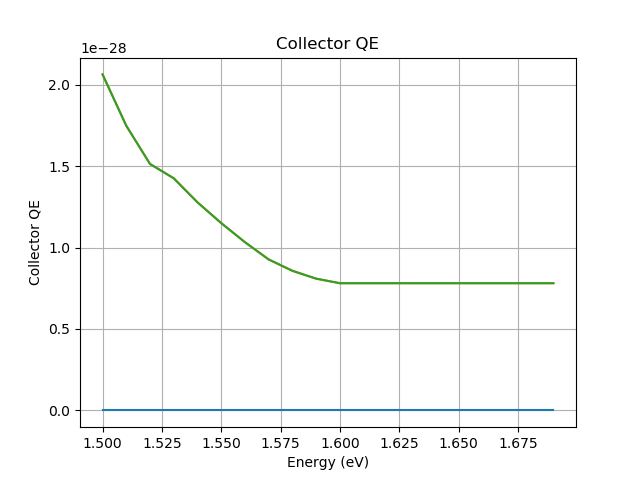

In [180]:

energy_i=1.5
energy_f=1.7
energy_step=0.01
# Data for plotting
elist = np.arange(energy_i, energy_f, energy_step)
curve=[]

for i in elist:
    curve.append([QCe(i,dictC,dictE,dictB),QCh(i,dictB,dictE),QCe(i,dictC,dictE,dictB)+QCh(i,dictB,dictE)])

fig, ax = plt.subplots()
ax.plot(elist, curve)

ax.set(xlabel='Energy (eV)', ylabel='Collector QE',
       title='Collector QE')
ax.grid()

fig.savefig("test.png")
plt.show()

## Plot of the Emitter Quantum Efficiency
* orange: contribution from emitter minority carriers
* blue: contribution from base minority carriers
* green: total

<IPython.core.display.Javascript object>


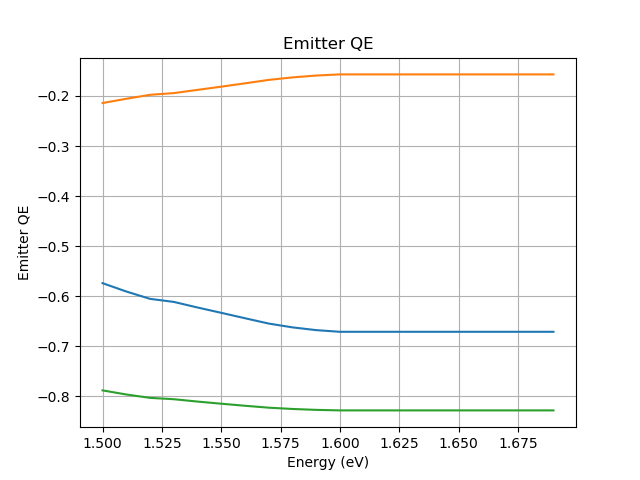

In [181]:

energy_i=1.5
energy_f=1.7
energy_step=0.01
# Data for plotting
elist = np.arange(energy_i, energy_f, energy_step)
curve=[]

for i in elist:
    curve.append([QEe(i,dictE),QEh(i,dictB,dictE),QEe(i,dictE)+QEh(i,dictB,dictE)])

fig, ax = plt.subplots()
ax.plot(elist, curve)

ax.set(xlabel='Energy (eV)', ylabel='Emitter QE',
       title='Emitter QE')
ax.grid()

fig.savefig("test.png")
plt.show()